# The project consists 5 steps:
## 1. Reading the data and preprocessing
## 2. EDA process and find trends / templates
## 3. Execution data mining algorithms 
## 4. Create prediction model for coke use
## 5. Create GUI for the model

# 1. Reading the data and preprocessing

In [1]:
# Import libraries
import json
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
import seaborn as sb
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import collections
from itertools import repeat

In [2]:
#Reading the data and round the values of the groups to 5 digit after the dot as the values mapping
data=pd.read_csv('drug_consumption.csv',encoding='latin')
cols_to_round=data.columns[1:11]
for col in cols_to_round:
    data[col]=data.apply(lambda row:'%.5f' %round(row[col],5),axis=1) 
Long_features_data=pd.read_csv('Long_features.csv',encoding='latin')
Long_features_data['Value']=Long_features_data.apply(lambda row:'%.5f' %float(row['Value']),axis=1) 

display(data.head())
display(Long_features_data.head())

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Coke
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL3
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL2
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL0


,Type,Value,Score
0,Nscore,-3.46436,12
1,Nscore,-3.15735,13
2,Nscore,-2.75696,14
3,Nscore,-2.52197,15
4,Nscore,-2.42317,16


In [3]:
# Create mapping of the features for the data

Short_Features_Mapping= """

{
    "Age": {
        "-0.95197": "18-24",
        "-0.07854": "25-34",
        "0.49788": "35-44",
        "1.09449": "45-54",
        "1.82213": "55-64",
        "2.59171": "65+"
    } ,
    "Gender": {
        "0.48246":"Female",
        "-0.48246":"Male"
    },
    "Education": {
        "-2.43591": "Left school before 16",
        "-1.73790": "Left school at 16",
        "-1.43719": "Left school at 17",
        "-1.22751": "Left school at 18",
        "-0.61113": "Some college or university, no certificate or degree",
        "-0.05921": "Professional certificate/ diploma",
        "0.45468": "University degree",
        "1.16365": "Masters degree",
        "1.98437": "Doctorate degree"
    },
        "Country": {
        "-0.09765": "Australia",
        "0.24923": "Canada",
        "-0.46841": "New Zealand",
        "-0.28519": "Other",
        "0.21128": "Republic of Ireland",
        "0.96082": "UK",
        "-0.57009": "USA"
    },
        "Ethnicity": {
            "-0.50212": "Asian",
            "-1.10702": "Black",
            "1.90725": "Mixed-Black/Asian",
            "0.12600": "Mixed-White/Asian",
            "-0.22166": "Mixed-White/Black",
            "0.11440": "Other",
            "-0.31685": "White"
    },
        "Coke": {
        "CL0": "Never Used",
        "CL1": "Used over a Decade Ago",
        "CL2": "Used in Last Decade",
        "CL3": "Used in Last Year",
        "CL4": "Used in Last Month",
        "CL5": "Used in Last Week",
        "CL6": "Used in Last Day"
    }
}
"""

# Convert JSON string to dictionary
Values_Mapping_Dict = json.loads(Short_Features_Mapping)
pprint.pprint(Values_Mapping_Dict)

{'Age': {'-0.07854': '25-34',
         '-0.95197': '18-24',
         '0.49788': '35-44',
         '1.09449': '45-54',
         '1.82213': '55-64',
         '2.59171': '65+'},
 'Coke': {'CL0': 'Never Used',
          'CL1': 'Used over a Decade Ago',
          'CL2': 'Used in Last Decade',
          'CL3': 'Used in Last Year',
          'CL4': 'Used in Last Month',
          'CL5': 'Used in Last Week',
          'CL6': 'Used in Last Day'},
 'Country': {'-0.09765': 'Australia',
             '-0.28519': 'Other',
             '-0.46841': 'New Zealand',
             '-0.57009': 'USA',
             '0.21128': 'Republic of Ireland',
             '0.24923': 'Canada',
             '0.96082': 'UK'},
 'Education': {'-0.05921': 'Professional certificate/ diploma',
               '-0.61113': 'Some college or university, no certificate or '
                           'degree',
               '-1.22751': 'Left school at 18',
               '-1.43719': 'Left school at 17',
               '-1.73790': 'L

In [4]:
# Convert the features to dict type
Nscore_data=Long_features_data[Long_features_data['Type']=='Nscore'][['Value']+['Score']]
Nscore_dict=dict(zip(Nscore_data.Value, Nscore_data.Score))

Escore_data=Long_features_data[Long_features_data['Type']=='Escore'][['Value']+['Score']]
Escore_dict=dict(zip(Escore_data.Value, Escore_data.Score))

Oscore_data=Long_features_data[Long_features_data['Type']=='Oscore'][['Value']+['Score']]
Oscore_dict=dict(zip(Oscore_data.Value, Oscore_data.Score))

Ascore_data=Long_features_data[Long_features_data['Type']=='Ascore'][['Value']+['Score']]
Ascore_dict=dict(zip(Ascore_data.Value, Ascore_data.Score))

Cscore_data=Long_features_data[Long_features_data['Type']=='Cscore'][['Value']+['Score']]
Cscore_dict=dict(zip(Cscore_data.Value, Cscore_data.Score))

In [5]:
# Active the mapping on the data set
#Long features
Values_Mapping_Dict['Nscore']= Nscore_dict
Values_Mapping_Dict['Escore']= Escore_dict
Values_Mapping_Dict['Oscore']= Oscore_dict
Values_Mapping_Dict['Ascore']= Ascore_dict
Values_Mapping_Dict['Cscore']= Cscore_dict

# Json format fearures
for col_map in Values_Mapping_Dict.keys():
        for key in Values_Mapping_Dict[col_map].keys():
            data[col_map]=data.apply(lambda row: Values_Mapping_Dict[col_map][key] if str(row[col_map])==key else row[col_map],axis=1)

In [6]:
data.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Coke
0,1,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,39,36,42,37,42,-0.21712,-1.18084,Never Used
1,2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,Used in Last Year
2,3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,Never Used
3,4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,Used in Last Decade
4,5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,Never Used


In [7]:
# Make the Coke used feature to binary: 1-used before, 0-Not used
data['Coke']=data.apply(lambda row: 0 if row['Coke']=='Never Used' else 1,axis=1) 

In [8]:
# Check the changes on the data
for col in data.columns[1:]:
    display(data[['ID',col]].groupby(col).count())

,ID
Age,
18-24,643
25-34,481
35-44,356
45-54,294
55-64,93
65+,18


,ID
Gender,
Female,942
Male,943


,ID
Education,
Doctorate degree,89
Left school at 16,99
Left school at 17,30
Left school at 18,100
Left school before 16,28
Masters degree,283
Professional certificate/ diploma,270
"Some college or university, no certificate or degree",506
University degree,480


,ID
Country,
Australia,54
Canada,87
New Zealand,5
Other,118
Republic of Ireland,20
UK,1044
USA,557


,ID
Ethnicity,
Asian,26
Black,33
Mixed-Black/Asian,3
Mixed-White/Asian,20
Mixed-White/Black,20
Other,63
White,1720


,ID
Nscore,
12,1
13,1
14,7
15,4
16,3
17,4
18,10
19,16
20,24


,ID
Escore,
16,2
18,1
19,6
20,3
21,3
22,8
23,5
24,9
25,4


,ID
Oscore,
24,2
26,4
28,4
29,11
30,9
31,9
32,13
33,23
34,25


,ID
Ascore,
12,1
16,1
18,1
23,1
24,2
25,1
26,7
27,7
28,8


,ID
Cscore,
17,1
19,1
20,3
21,2
22,5
23,5
24,6
25,9
26,13


,ID
Impulsive,
-2.55524,20
-1.37983,276
-0.71126,307
-0.21712,355
0.19268,257
0.52975,216
0.88113,195
1.29221,148
1.86203,104


,ID
SS,
-2.07848,71
-1.54858,87
-1.18084,132
-0.84637,169
-0.52593,211
-0.21575,223
0.07987,219
0.40148,249
0.76540,211


,ID
Coke,
0,1038
1,847


In [9]:
display(data.head())

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Coke
0,1,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,39,36,42,37,42,-0.21712,-1.18084,0
1,2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,1
2,3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,0
3,4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,1
4,5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,0


In [10]:
# # Export the resolts
# data.to_csv("drugs_maping.csv", encoding="utf-8",index=False)

# 2. EDA

In [11]:
display(data.info())
# Non null values    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1885 non-null   int64  
 1   Age        1885 non-null   object 
 2   Gender     1885 non-null   object 
 3   Education  1885 non-null   object 
 4   Country    1885 non-null   object 
 5   Ethnicity  1885 non-null   object 
 6   Nscore     1885 non-null   int64  
 7   Escore     1885 non-null   int64  
 8   Oscore     1885 non-null   int64  
 9   Ascore     1885 non-null   int64  
 10  Cscore     1885 non-null   int64  
 11  Impulsive  1885 non-null   float64
 12  SS         1885 non-null   float64
 13  Coke       1885 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 206.3+ KB


None

In [12]:
# Check the numeric values without the id column
data[data.columns[1:]].describe()
# The data looks normal

,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Coke
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,35.921485,39.576127,45.762334,42.866313,41.437135,0.007216,-0.003292,0.449337
std,9.135869,6.771769,6.579641,6.438106,6.966625,0.954435,0.963701,0.497559
min,12.000000,16.000000,24.000000,12.000000,17.000000,-2.555240,-2.078480,0.000000
25%,29.000000,35.000000,41.000000,39.000000,37.000000,-0.711260,-0.525930,0.000000
50%,36.000000,40.000000,46.000000,43.000000,42.000000,-0.217120,0.079870,0.000000
75%,42.000000,44.000000,51.000000,48.000000,46.000000,0.529750,0.765400,1.000000
max,60.000000,59.000000,60.000000,60.000000,59.000000,2.901610,1.921730,1.000000


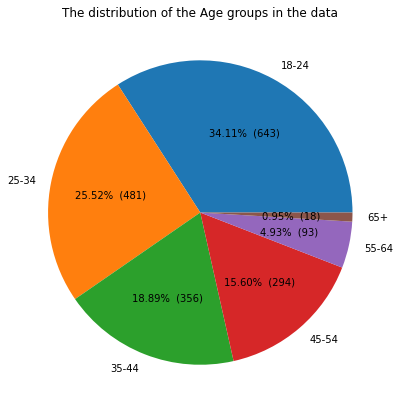

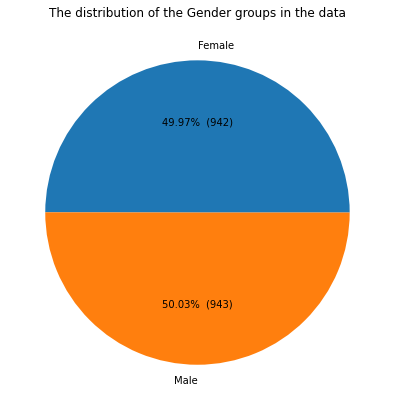

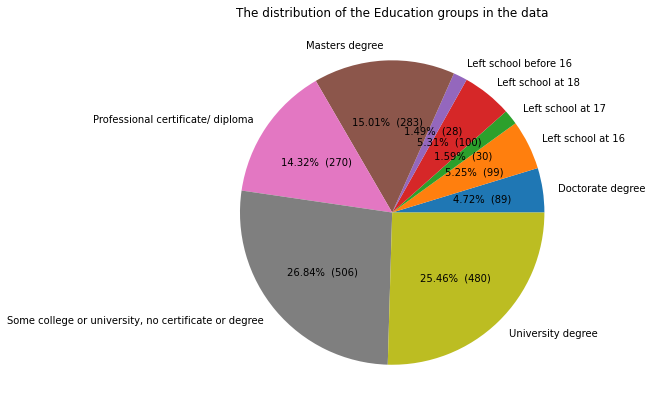

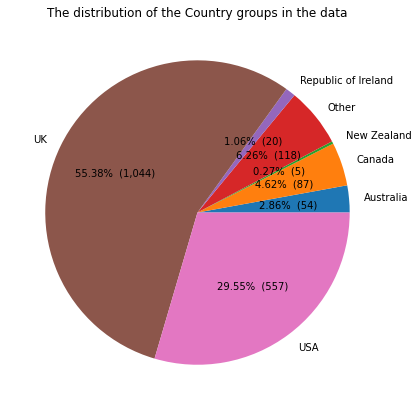

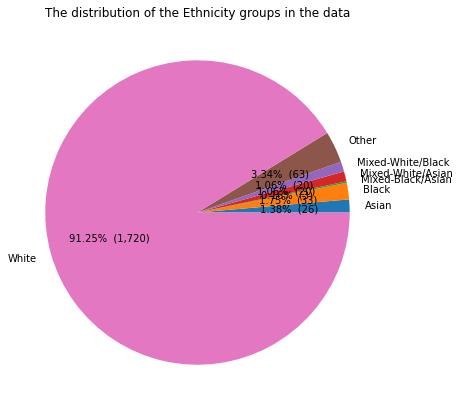

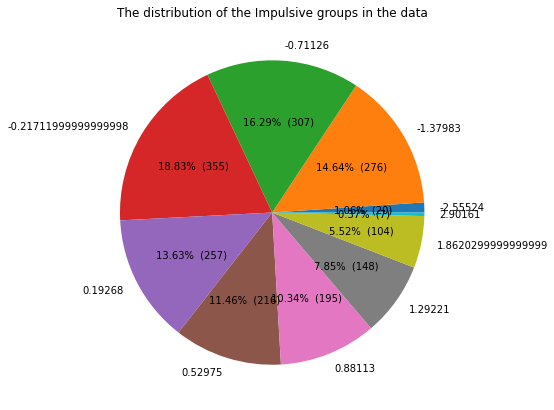

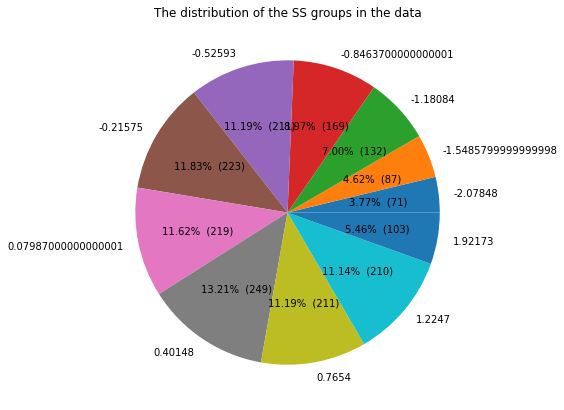

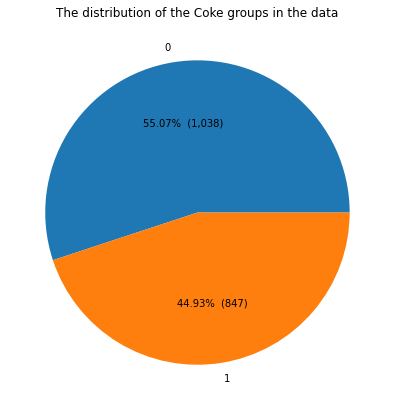

In [13]:
# Data distribution - Pie graphs
Pie_cols=data.columns[[1,2,3,4,5,11,12,13]]
for col in Pie_cols:
    Pie_data=data[[col,'ID']].groupby(col).count().reset_index()
    labels=Pie_data[col].to_list()
    plt.figure(figsize=(15, 7))
    plt.pie(Pie_data['ID'], labels=labels, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(Pie_data['ID'])/100))
    title='The distribution of the',col,'groups in the data'
    title=str(title)
    title=title.replace(',','')
    title=title.replace("'",'')
    title=title.replace(")",'')
    title=title.replace("(",'')
    plt.title(title)
    plt.show()

<AxesSubplot:>

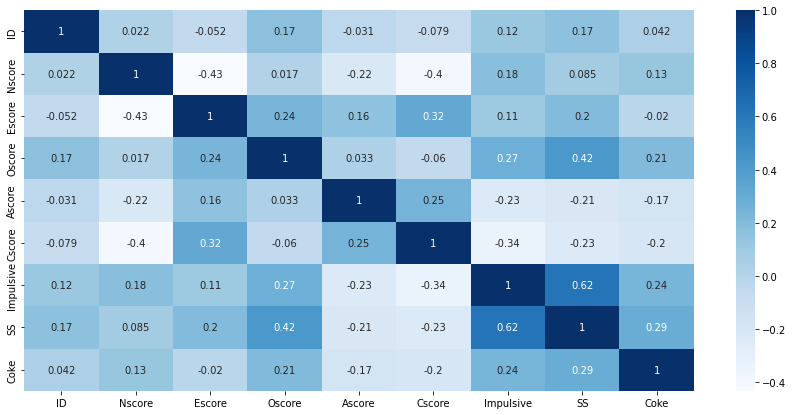

In [14]:
# Check correlation on between features
plt.figure(figsize=(15, 7))
corr = data.corr()
sb.heatmap(corr, cmap="Blues", annot=True)

In [15]:
def Create_Bar_Charts(col,data):
    data=data
    grouped_data=data[[col,'Coke']].groupby([col,'Coke']).size()
    grouped_data=pd.DataFrame(grouped_data).reset_index()
    grouped_data=grouped_data.rename(columns={0: 'Count'})
    grouped_data['Count_Not_used']=grouped_data.apply(lambda row: row['Count'] if row['Coke']==0 else np.nan, axis=1)
    grouped_data['Count_used']=grouped_data.apply(lambda row: row['Count'] if row['Coke']==1 else np.nan, axis=1)
    Bar_chart_data=grouped_data[[col,'Count_Not_used','Count_used']].groupby(col).max()
    Bar_chart_data['Total']=Bar_chart_data['Count_Not_used']+Bar_chart_data['Count_used']
    Bar_chart_data['Percent_used_coke']=round((Bar_chart_data['Count_used']/Bar_chart_data['Total'])*100,1)
    Bar_chart_data['Percent_not_used_coke']=round((Bar_chart_data['Count_Not_used']/Bar_chart_data['Total'])*100,1)
    Bar_chart_data=Bar_chart_data.reset_index()
    Bar_chart_data=Bar_chart_data[[col,'Percent_used_coke','Percent_not_used_coke']]

    X_axis = np.arange(len(Bar_chart_data[col].unique()))
    plt.figure(figsize=(15, 7))
    plt.bar(X_axis - 0.1, Bar_chart_data['Percent_used_coke'], 0.2, label = 'Used_coke (%)')
    plt.bar(X_axis + 0.1, Bar_chart_data['Percent_not_used_coke'], 0.2, label = 'Not_used_coke (%)')
    plt.xticks(X_axis, Bar_chart_data[col].unique(), rotation=70)
    plt.legend()
    title='The distribution of the',col,'groups used in cocaine'
    title=str(title)
    title=title.replace(',','')
    title=title.replace("'",'')
    title=title.replace(")",'')
    title=title.replace("(",'')
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Percent (%)')


    for i in range(len(Bar_chart_data['Percent_used_coke'])):
        plt.annotate(str(round(Bar_chart_data['Percent_used_coke'][i],2)), xy=(X_axis[i],Bar_chart_data['Percent_used_coke'][i]), ha='right', va='bottom')

    for i in range(len(Bar_chart_data['Percent_not_used_coke'])):
        plt.annotate(str(round(Bar_chart_data['Percent_not_used_coke'][i],2)), xy=(X_axis[i],Bar_chart_data['Percent_not_used_coke'][i]), ha='left', va='bottom')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
    plt.show()

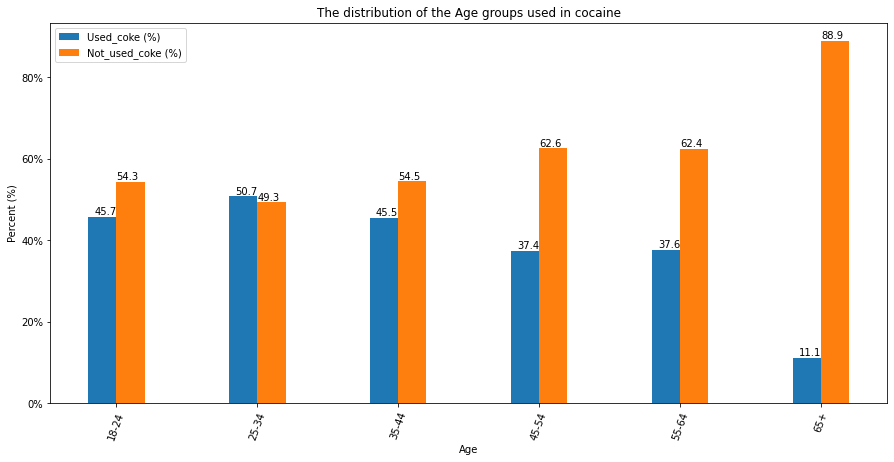

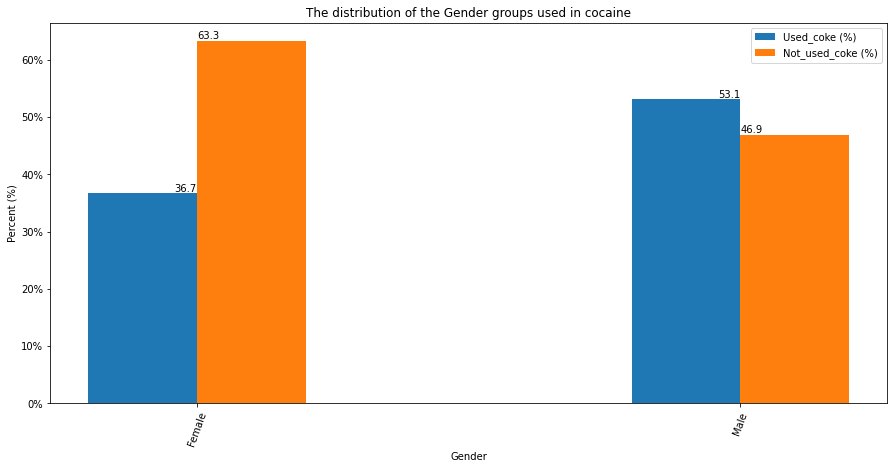

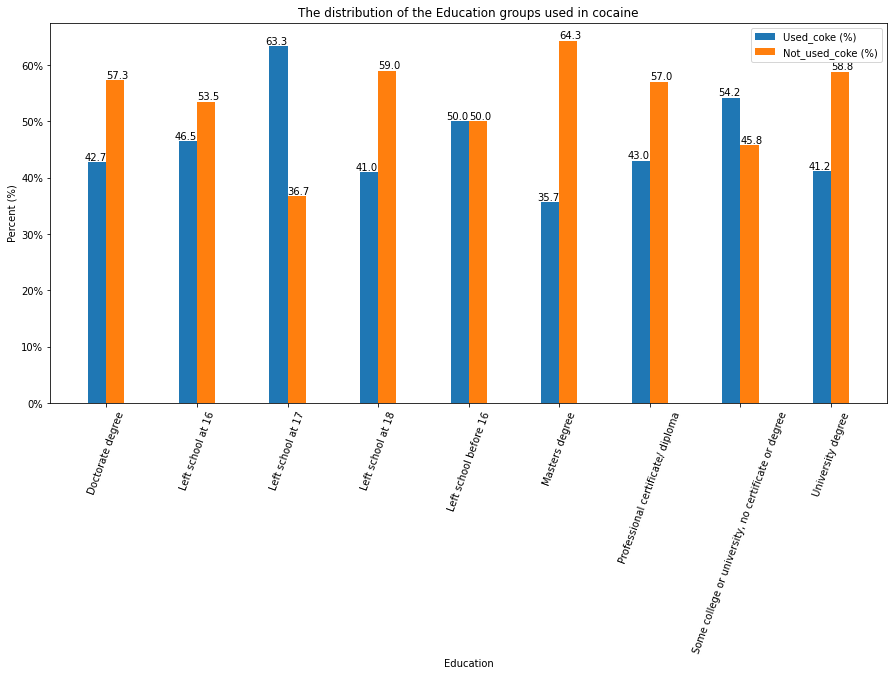

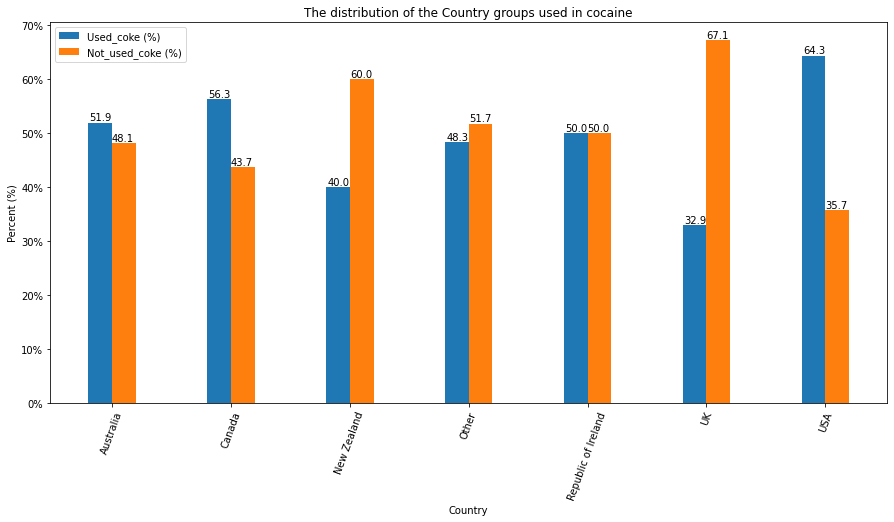

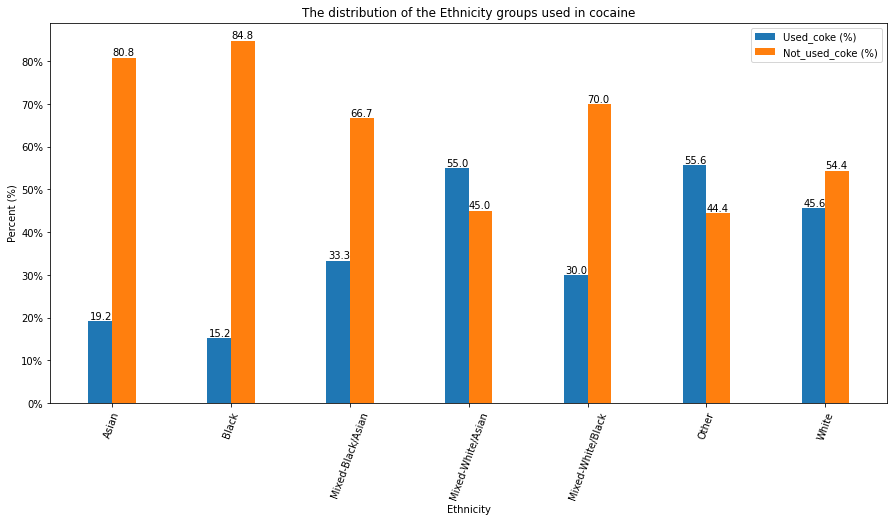

In [16]:
# Bar charts for the non numeric values
Bar_columns=data.columns[1:6]
for col in Bar_columns:
    Create_Bar_Charts(col,data)

<ipython-input-17-a305867a0477>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Personal_data[str(Personal_val)+'_Score'] = Personal_data.apply(lambda row: 1 if row[col] == Personal_val else np.nan ,axis=1)


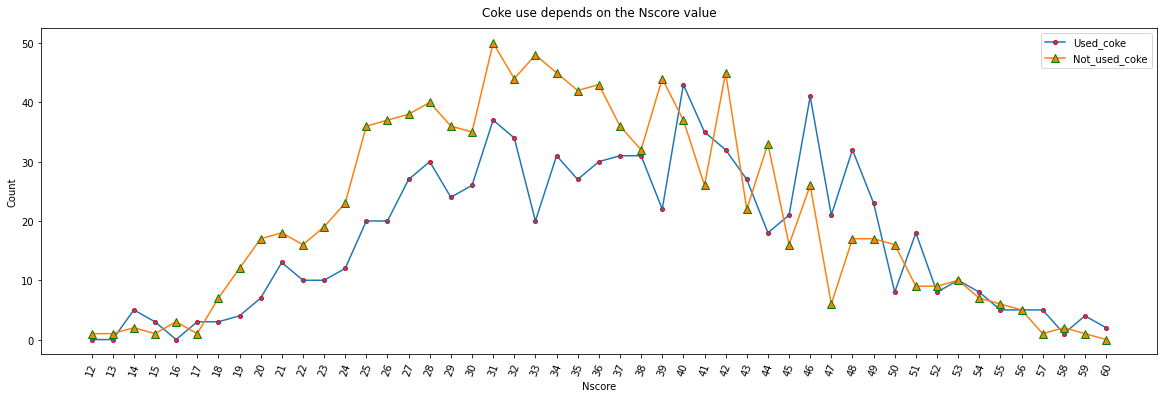

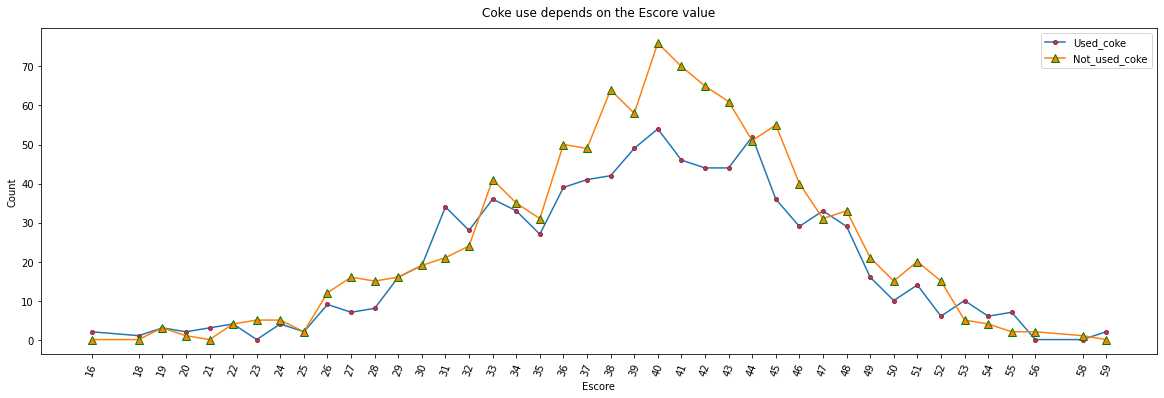

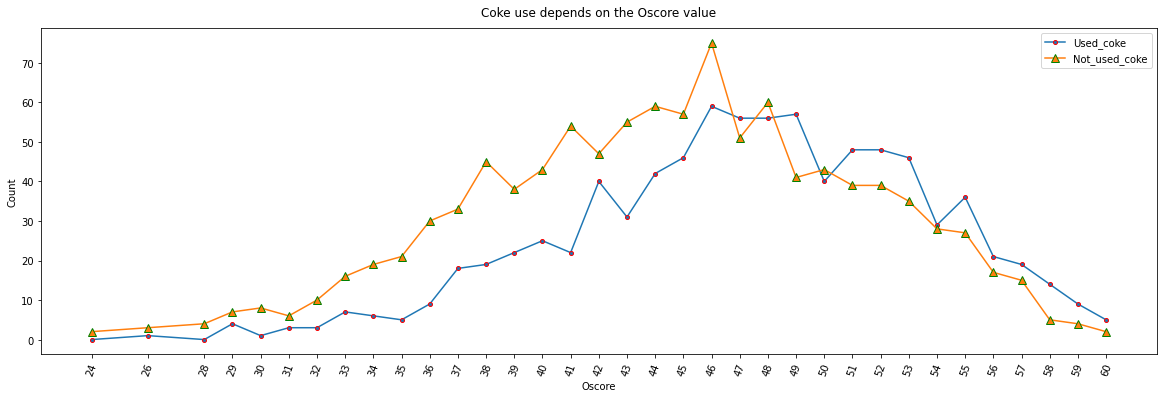

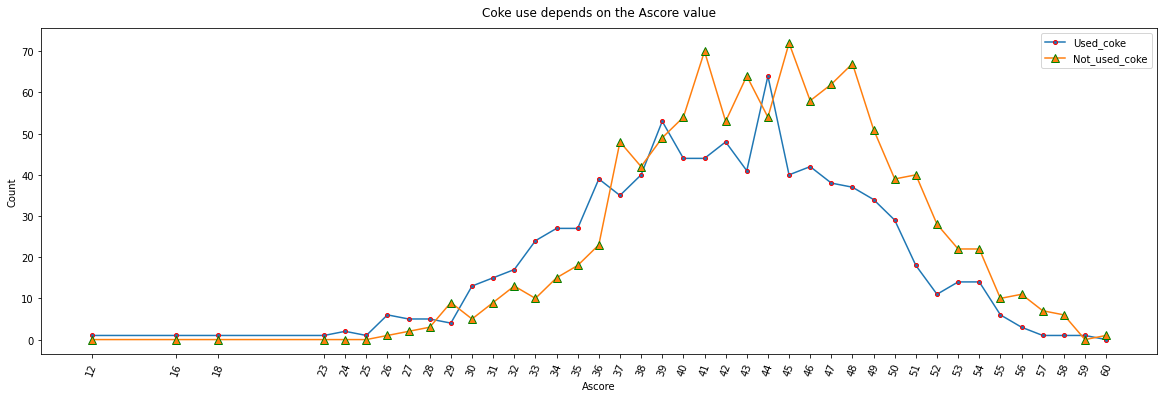

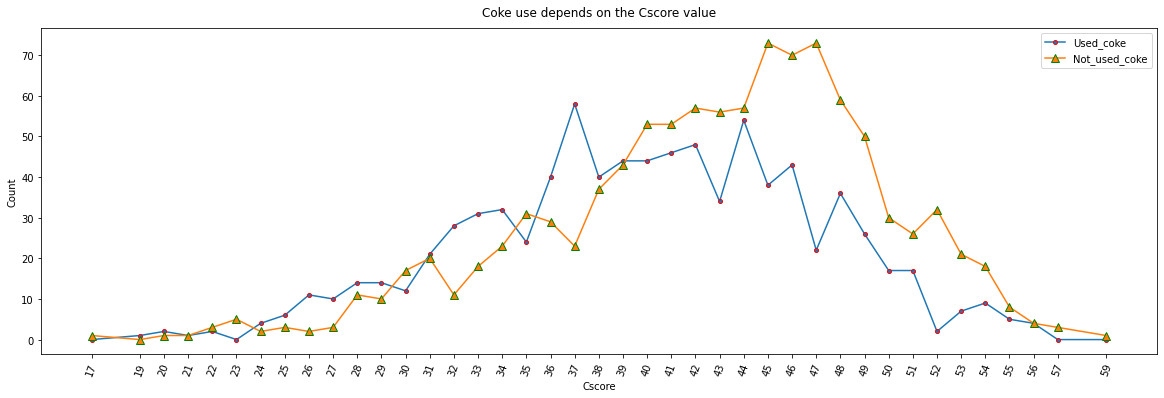

In [17]:
# Big Five personality traits - Coke use graphs
Big_five_cols=data.columns[6:11]
for col in Big_five_cols:
    Personal_data=data[['ID',col,'Coke']]
    Personal_list=Personal_data[col].to_list()
    Personal_list.sort()
    Personal_list=list(set(Personal_list))
    for Personal_val in Personal_list:
        Personal_data[str(Personal_val)+'_Score'] = Personal_data.apply(lambda row: 1 if row[col] == Personal_val else np.nan ,axis=1)
    Personal_data_grouped=Personal_data.iloc[:,2:].groupby('Coke').count().reset_index()
    Personal_not_used = Personal_data_grouped.iloc[0:1,1:].values.tolist()[0]
    Personal_used = Personal_data_grouped.iloc[1:,1:].values.tolist()[0]
    plt.figure(figsize=(20, 6))
    plt.plot(Personal_list, Personal_used, label='Used_coke', marker='.',markersize=8, markeredgecolor='r')
    plt.plot(Personal_list, Personal_not_used, label='Not_used_coke', marker='^',markersize=8, markeredgecolor='g')
    
    title='Coke use depends on the',col,'value'
    title=str(title)
    title=title.replace(',','')
    title=title.replace("'",'')
    title=title.replace(")",'')
    title=title.replace("(",'')
    plt.title(title, loc='center', pad=12.0)
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.xticks(Personal_list, rotation=70) 
    plt.legend()
    plt.show()

In [18]:
Other_features_col=data.columns[11:-1]
Other_features_col

Index(['Impulsive', 'SS'], dtype='object')

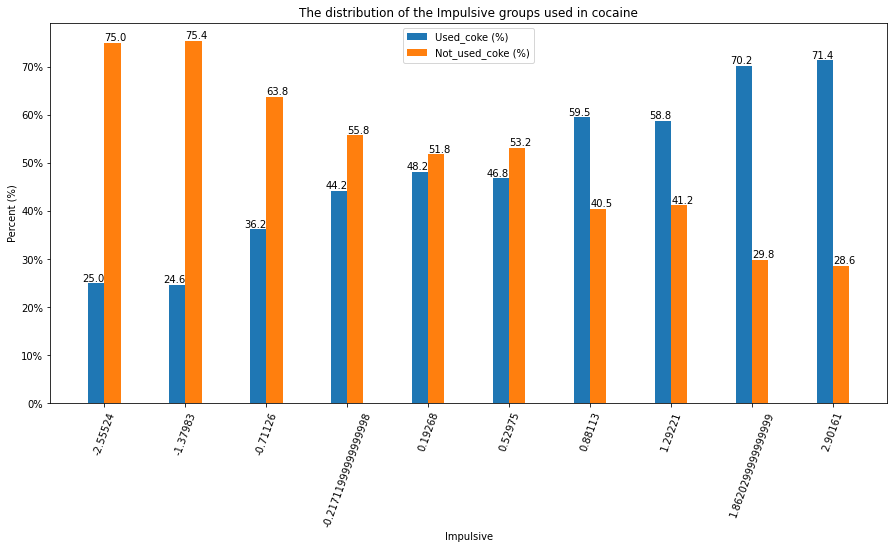

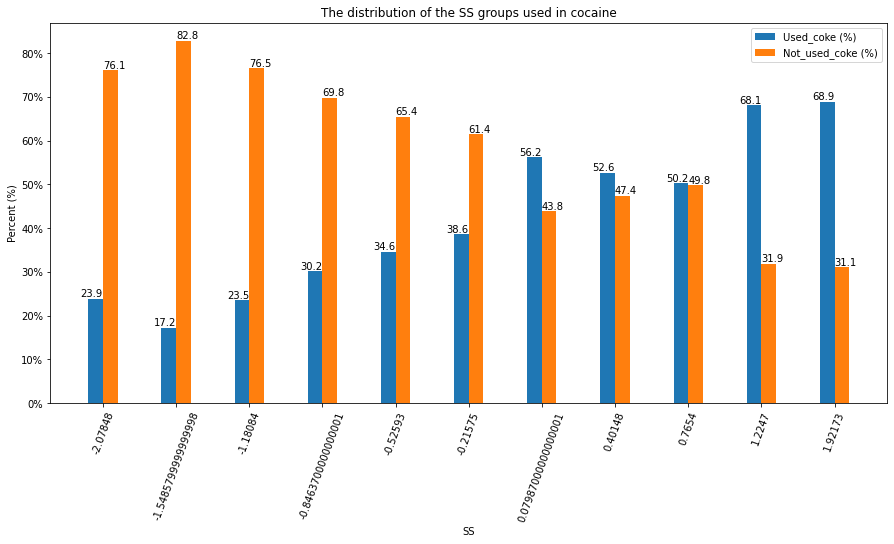

In [19]:
# Bar charts for Impulsive and SS features
Other_features_col=data.columns[11:-1]
for col in Other_features_col:
    Create_Bar_Charts(col,data)

# 3. Data mining algorithms

For n_clusters = 2 The average silhouette_score is : 0.22266836455775485
The distribution of the clusters is : Counter({1: 1079, 0: 806})
For n_clusters = 3 The average silhouette_score is : 0.17747844795874682
The distribution of the clusters is : Counter({1: 681, 0: 602, 2: 602})
For n_clusters = 4 The average silhouette_score is : 0.16251232111135785
The distribution of the clusters is : Counter({3: 496, 1: 494, 0: 483, 2: 412})
For n_clusters = 5 The average silhouette_score is : 0.16461169842035928
The distribution of the clusters is : Counter({3: 440, 4: 401, 0: 400, 2: 335, 1: 309})
For n_clusters = 6 The average silhouette_score is : 0.15993383525726151
The distribution of the clusters is : Counter({3: 399, 1: 364, 0: 325, 5: 312, 4: 261, 2: 224})


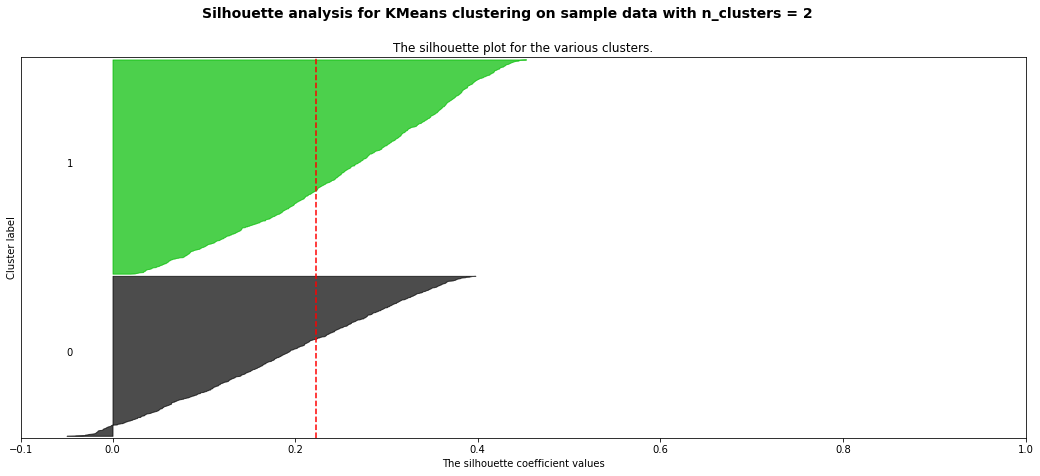

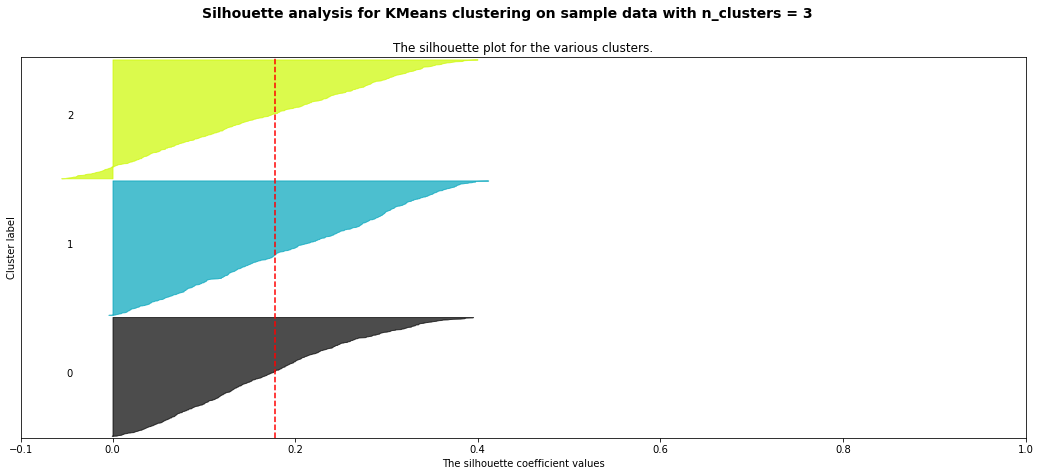

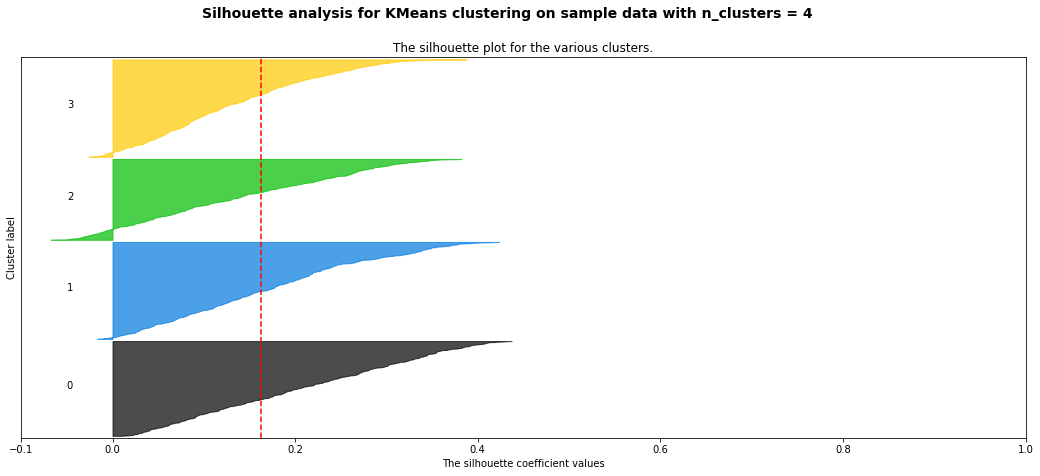

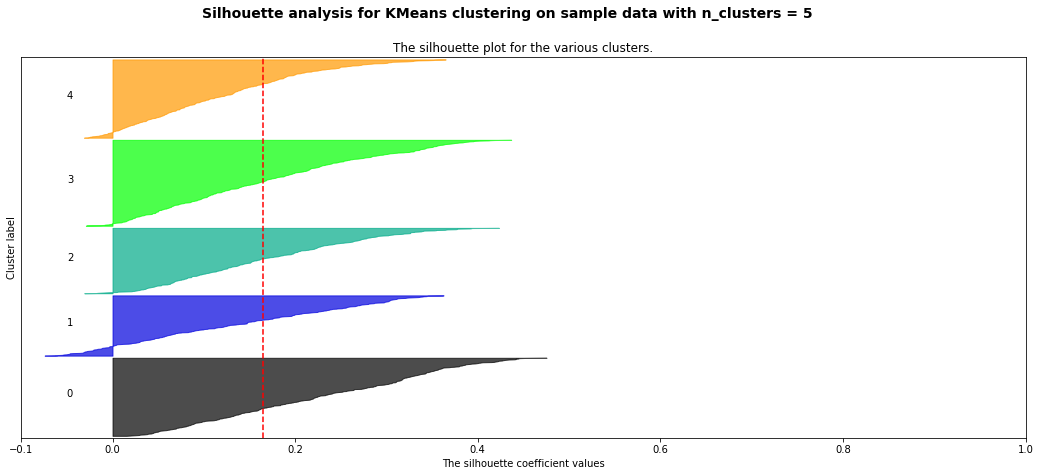

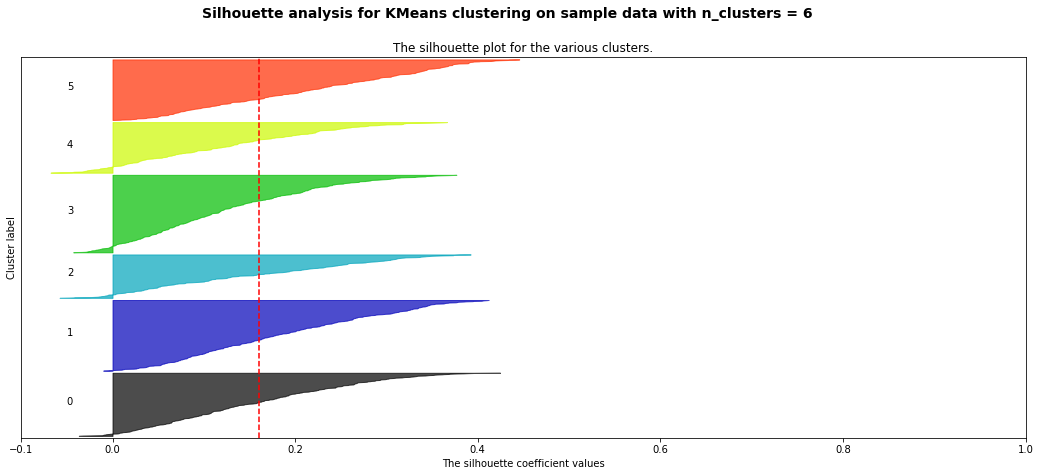

In [20]:
# Kmeans
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
X=data.iloc[:,6:11]
sc_x = StandardScaler()
X=sc_x.fit_transform(X)
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    print('The distribution of the clusters is :', collections.Counter(list(cluster_labels)))
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()

In [21]:
# add the best score of k-means (k=2) as feature 
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels = clusterer.fit_predict(X)
data['big_Five_K2means']=cluster_labels

In [22]:
# Make clustring by using DBSCAN algorithm
Big_Five_data=data.iloc[:,6:11]
sc_x = StandardScaler()
Big_Five_data=sc_x.fit_transform(Big_Five_data)

db_default = DBSCAN(eps = 1.2, min_samples = 6).fit(Big_Five_data)
labels = db_default.labels_
print('The clusters are: ',set(list(labels)))
sample_silhouette_values = silhouette_score(Big_Five_data, labels)
print('The silhouette score for the clusters is: ',sample_silhouette_values)
print('The distribution of the clusters is :', collections.Counter(list(labels)))
print('The lables are:')
print(list(labels))

The clusters are:  {0, -1}
The silhouette score for the clusters is:  0.3120604812686787
The distribution of the clusters is : Counter({0: 1819, -1: 66})
The lables are:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Binning

In [23]:
# age binning
def age_b (age):
    if age == "18-24" or age == "35-44":
        return "Group-1"
    elif age == "45-54" or age == "55-64":
        return "Group-2"
    elif age == "65+":
        return "Group-3" 
    else:
        return "Group-4"

In [24]:
# education binning
def education_b (education):
    if education.startswith("Left") or education.startswith("Some"):
        return "not_higher_educated"
    else:
        return "higher_educated"

In [25]:
# continent binning
def continent_b (country):
    if country == "Australia" or country == "New Zealand":
        return "Oceania"
    elif country == "Canada" or country == "USA":
        return "America"
    elif country == "Republic of Ireland" or country == "UK":
        return "Europe"   
    else:
        return "Other"

In [26]:
# country binning
def country_b (country):
    if country == "USA":
        return "USA"
    elif country == "UK":
        return "UK"   
    else:
        return "Other"

In [27]:
# ethnicity binning
def ethnicity_b (ethnicity):
    if ethnicity == "White":
        return "White"
    else:
        return "Other"

In [28]:
# Create new features to the data for the prediction
data['Age_bining'] = data.apply(lambda row: age_b(row['Age']) ,axis=1)
data['Education_bining'] = data.apply(lambda row: education_b(row['Education']) ,axis=1)
data['Continent'] = data.apply(lambda row: continent_b(row['Country']) ,axis=1)
data['Country_bining'] = data.apply(lambda row: country_b(row['Country']) ,axis=1)
data['Ethnicity_bining'] = data.apply(lambda row: ethnicity_b(row['Ethnicity']) ,axis=1)
data = data[ [ col for col in data.columns if col != 'Coke' ] + ['Coke'] ]
data.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,big_Five_K2means,Age_bining,Education_bining,Continent,Country_bining,Ethnicity_bining,Coke
0,1,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,39,36,42,37,42,-0.21712,-1.18084,0,Group-1,higher_educated,Europe,UK,Other,0
1,2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,1,Group-4,higher_educated,Europe,UK,White,1
2,3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,0,Group-1,higher_educated,Europe,UK,White,0
3,4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,1,Group-1,higher_educated,Europe,UK,White,1
4,5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,0,Group-1,higher_educated,Europe,UK,White,0


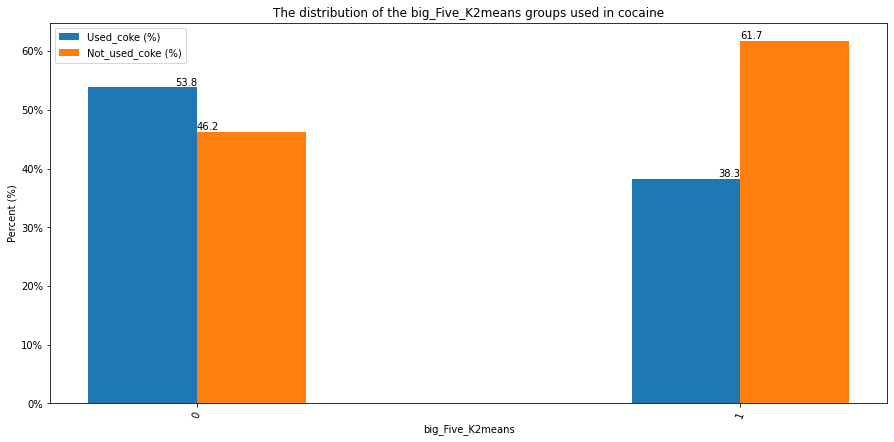

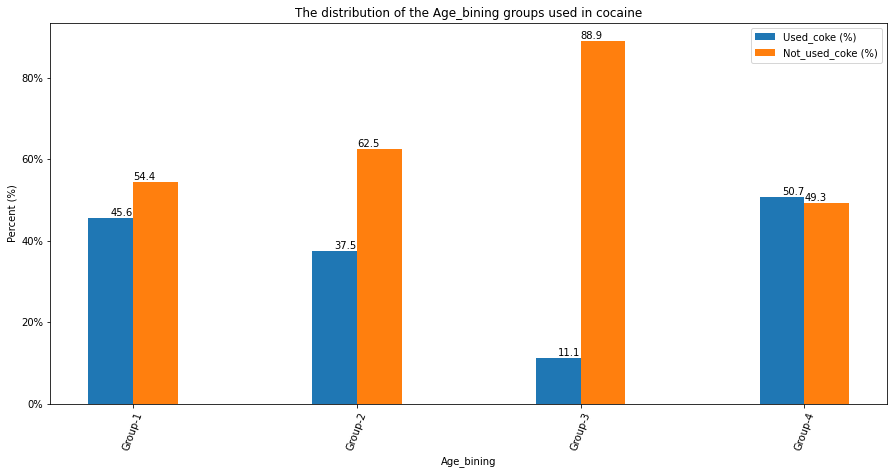

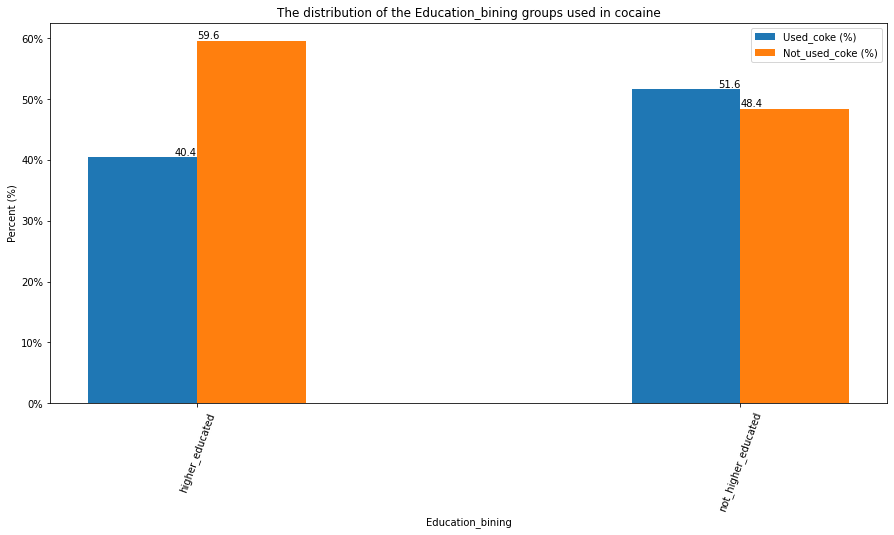

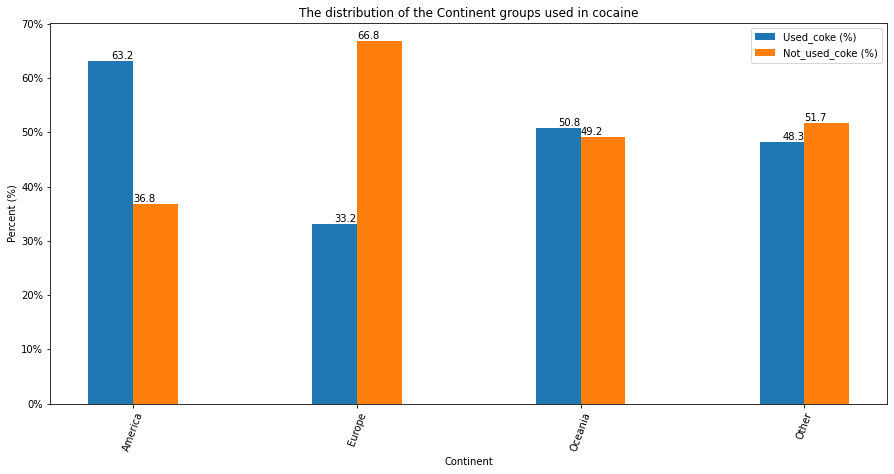

In [29]:
# Bar charts to view the affect of the bining visually
Bar_columns2=data.columns[13:17]
for col in Bar_columns2:
    Create_Bar_Charts(col,data)

In [30]:
# Explore the distribution of the clustring devition 
Clustring_0_data=data[data['big_Five_K2means']==0]
Clustring_1_data=data[data['big_Five_K2means']==1]
display(Clustring_0_data.head())
display(Clustring_1_data.head())

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,big_Five_K2means,Age_bining,Education_bining,Continent,Country_bining,Ethnicity_bining,Coke
0,1,35-44,Female,Professional certificate/ diploma,UK,Mixed-White/Asian,39,36,42,37,42,-0.21712,-1.18084,0,Group-1,higher_educated,Europe,UK,Other,0
2,3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,0,Group-1,higher_educated,Europe,UK,White,0
4,5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,0,Group-1,higher_educated,Europe,UK,White,0
12,13,55-64,Female,University degree,UK,White,56,41,49,32,36,1.29221,0.07987,0,Group-2,higher_educated,Europe,UK,White,1
17,18,45-54,Male,Left school at 16,UK,White,41,31,44,40,31,-1.37983,-0.84637,0,Group-2,not_higher_educated,Europe,UK,White,1


,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,big_Five_K2means,Age_bining,Education_bining,Continent,Country_bining,Ethnicity_bining,Coke
1,2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,1,Group-4,higher_educated,Europe,UK,White,1
3,4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,1,Group-1,higher_educated,Europe,UK,White,1
5,6,65+,Female,Left school at 18,Canada,White,29,38,35,55,52,-1.37983,-1.54858,1,Group-3,not_higher_educated,America,Other,White,0
6,7,45-54,Male,Masters degree,USA,White,31,32,43,41,48,-0.21712,0.07987,1,Group-2,higher_educated,America,USA,White,0
7,8,35-44,Male,Left school at 16,UK,White,24,52,40,41,52,0.19268,-0.52593,1,Group-1,not_higher_educated,Europe,UK,White,0


In [31]:
# Explore the number of coke use between 2 groups
Group_0_coke_use=Clustring_0_data[['ID','Coke']].groupby('Coke').count()
Group_0_coke_use=Group_0_coke_use.style.set_caption('Cluster number 0')
Group_1_coke_use=Clustring_1_data[['ID','Coke']].groupby('Coke').count()
Group_1_coke_use=Group_1_coke_use.style.set_caption('Cluster number 1')

display(Group_0_coke_use) # More people used coke
display(Group_1_coke_use) # More people not used in coke

,ID
Coke,
0,372
1,434


,ID
Coke,
0,666
1,413


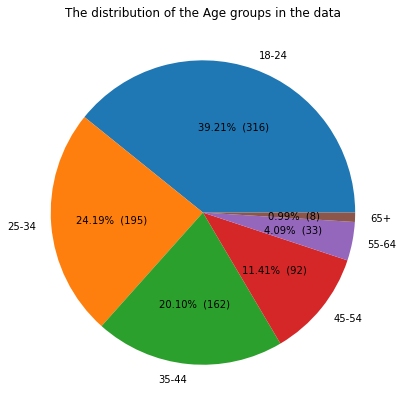

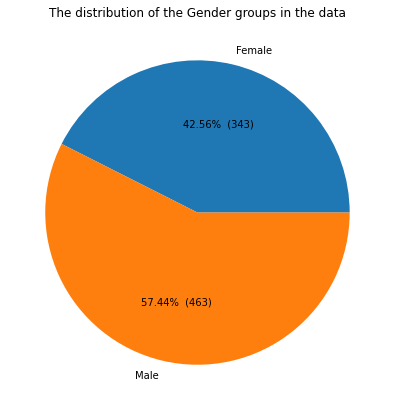

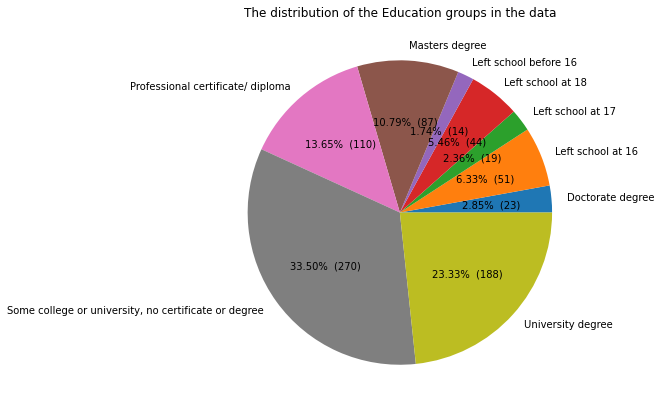

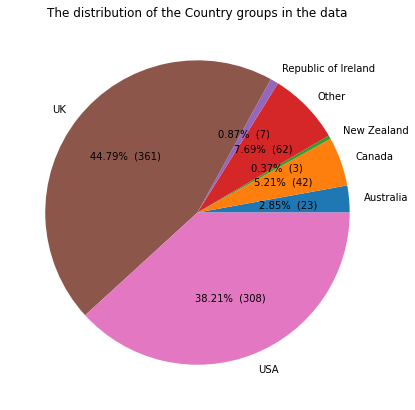

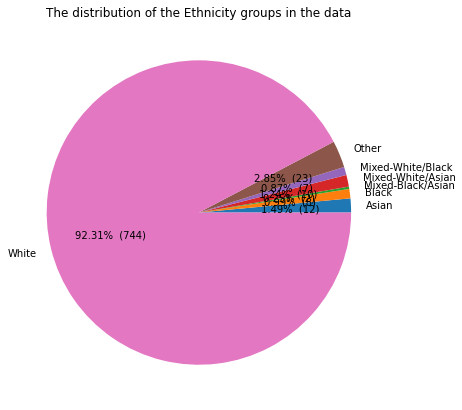

In [32]:
# Data distribution - Pie graphs
Pie_cols_cluster_0=Clustring_0_data.columns[1:6]
for col in Pie_cols_cluster_0:
    Pie_data=Clustring_0_data[[col,'ID']].groupby(col).count().reset_index()
    labels=Pie_data[col].to_list()
    plt.figure(figsize=(15, 7))
    plt.pie(Pie_data['ID'], labels=labels, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(Pie_data['ID'])/100))
    title='The distribution of the',col,'groups in the data'
    title=str(title)
    title=title.replace(',','')
    title=title.replace("'",'')
    title=title.replace(")",'')
    title=title.replace("(",'')
    plt.title(title)
    plt.show()

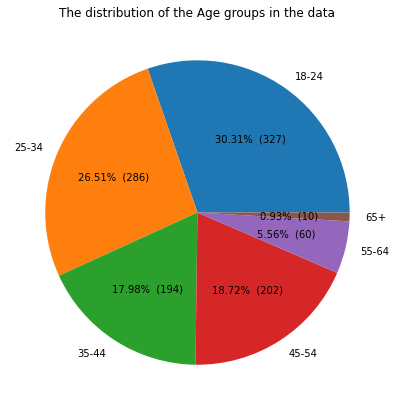

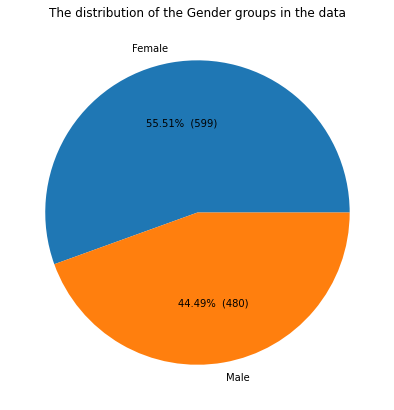

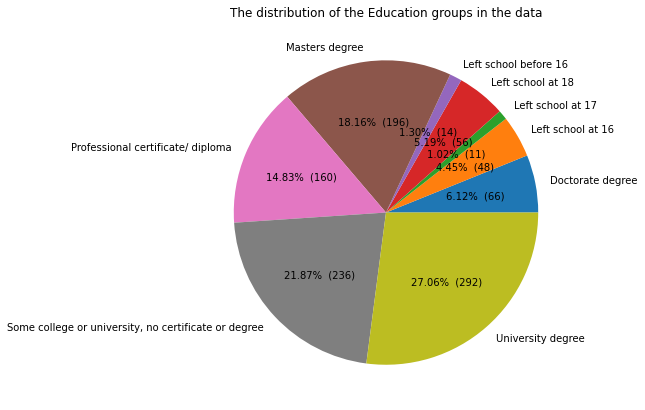

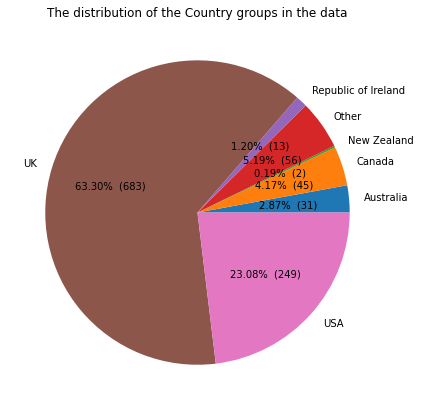

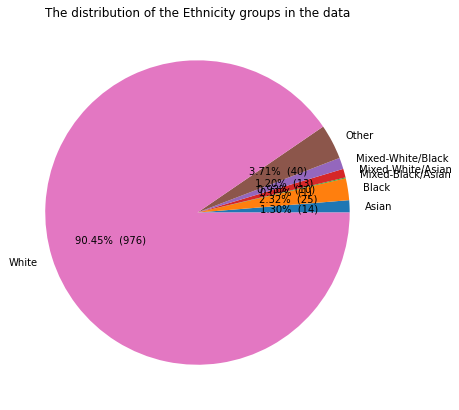

In [33]:
# Data distribution - Pie graphs
Pie_cols_cluster_1=Clustring_1_data.columns[1:6]
for col in Pie_cols_cluster_1:
    Pie_data=Clustring_1_data[[col,'ID']].groupby(col).count().reset_index()
    labels=Pie_data[col].to_list()
    plt.figure(figsize=(15, 7))
    plt.pie(Pie_data['ID'], labels=labels, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(Pie_data['ID'])/100))
    title='The distribution of the',col,'groups in the data'
    title=str(title)
    title=title.replace(',','')
    title=title.replace("'",'')
    title=title.replace(")",'')
    title=title.replace("(",'')
    plt.title(title)
    plt.show()

# Create prediction model for coke use

## Random Forest Model

In [34]:
# Remove the ID column
del data['ID']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

In [36]:
Data_prediction=pd.get_dummies(data)
Data_prediction = Data_prediction[ [ col for col in Data_prediction.columns if col != 'Coke' ] + ['Coke'] ]
X=Data_prediction.iloc[:,:-1].values
y=Data_prediction.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0,stratify=y)

# מציאת מספר העצים ועומק העצים הכי טוב מבין האפשרויות 
Random_Forest=RandomForestClassifier(random_state=0)
parameters = {'n_estimators': [50,75,100,125,150,200],'max_depth': [2,4,6,8,10]}
cv=KFold(n_splits=8)
search = GridSearchCV(estimator=Random_Forest, param_grid=parameters,scoring='roc_auc',cv=cv)
result=search.fit(X_train, y_train)
print('The hyperparameter optimization results: ')
print('Best AUC ROC Score: %s' % result.best_score_)
print('Best Hyperparameters are - max_depth and n_estimators: %s' % result.best_params_)
print()

The hyperparameter optimization results: 
Best AUC ROC Score: 0.75579286658441
Best Hyperparameters are - max_depth and n_estimators: {'max_depth': 8, 'n_estimators': 100}



Random Forest
The hyperparameter optimization results: 
Best AUC ROC Score: 0.75579286658441
Best Hyperparameters are - max_depth and n_estimators: {'max_depth': 8, 'n_estimators': 100}
F-1 Score:  0.6586345381526105


<AxesSubplot:title={'center':'Feature importance'}>

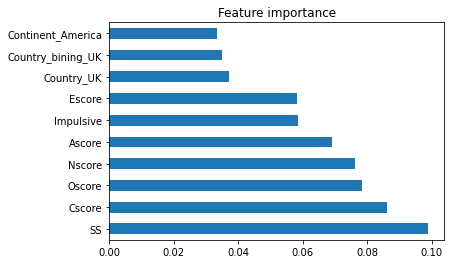

In [37]:
from sklearn.metrics import f1_score
Random_Forest=RandomForestClassifier(max_depth= 8, n_estimators=100, random_state=0)
Random_Forest_Model=Random_Forest.fit(X_train,y_train)
y_pred=Random_Forest_Model.predict(X_test)

f1_score_result=f1_score(y_test,y_pred)
print('Random Forest')
print('The hyperparameter optimization results: ')
print('Best AUC ROC Score: %s' % result.best_score_)
print('Best Hyperparameters are - max_depth and n_estimators: %s' % result.best_params_)
print('F-1 Score: ',f1_score_result)

plt.title('Feature importance')
feat_importances = pd.Series(Random_Forest_Model.feature_importances_, index=Data_prediction.columns[:-1])
feat_importances.nlargest(10).plot(kind='barh')

## Adaboost Model

In [38]:
tree= DecisionTreeClassifier()
abc=AdaBoostClassifier(base_estimator=tree,learning_rate=1,random_state=0)

parameters = {'n_estimators': [50,75,100,125,150,175,200]}
cv=KFold(n_splits=8)
search = GridSearchCV(estimator=abc, param_grid=parameters,scoring='roc_auc',cv=cv)
result=search.fit(X_train, y_train)
print('The hyperparameter optimization results: ')
print('Best AUC ROC Score: %s' % result.best_score_)
print('Best Hyperparameter is -  n_estimators: %s' % result.best_params_)
print()

The hyperparameter optimization results: 
Best AUC ROC Score: 0.5956123638473988
Best Hyperparameter is -  n_estimators: {'n_estimators': 50}



F-1 Score:  0.5196850393700787


<AxesSubplot:title={'center':'Feature importance'}>

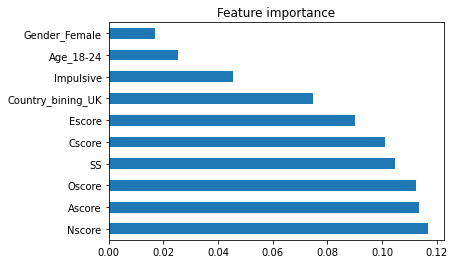

In [39]:
from sklearn.metrics import f1_score
tree= DecisionTreeClassifier()
abc=AdaBoostClassifier(n_estimators=50,base_estimator=tree,learning_rate=1,random_state=0)
model=abc.fit(X_train,y_train)
y_pred=model.predict(X_test)

f1_score_result=f1_score(y_test,y_pred)
print('F-1 Score: ',f1_score_result)

plt.title('Feature importance')
feat_importances = pd.Series(model.feature_importances_, index=Data_prediction.columns[:-1])
feat_importances.nlargest(10).plot(kind='barh')

# ANN

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

# we tried scalling, but it produced a worst model
Ann_Model = MLPClassifier(hidden_layer_sizes=(20,20,20),max_iter=800, random_state=0)
Ann_Model.fit(X_train,y_train)

#print(confusion_matrix(y_test,predictions))
#print(classification_report(y_test,predictions))

f1_score_result=f1_score(y_test,Ann_Model.predict(X_test))
print('ANN')
print('F-1 Score: ',f1_score_result)
print('roc_auc_score: ',roc_auc_score(y_test, Ann_Model.predict_proba(X_test)[:, 1]))

ANN
F-1 Score:  0.6307053941908713
roc_auc_score:  0.7702402584292348


# Create GUI for the model

In [41]:
import gradio as gr

In [42]:
def greet(Nscore, Escore, Oscore, Ascore, Cscore, Impulsive, SS, Age_group, Gender, Education, Country, Ethnicity):
    big_Five_K2means = clusterer.predict(sc_x.transform([[Nscore, Escore, Oscore, Ascore, Cscore]]))
    
    zero_list = []
    zero_list.extend(repeat(0,46))
    Age_18_24, Age_25_34, Age_35_44, Age_45_54,Age_55_64, Age_above_65, Gender_Female, Gender_Male,Education_Doctorate_degree, Education_Left_school_at_16,Education_Left_school_at_17, Education_Left_school_at_18,Education_Left_school_before_16, Education_Masters_degree,Education_Professional_certificate_or_diploma,Education_Some_college_or_university_no_certificate_or_degree,Education_University_degree, Country_Australia, Country_Canada,Country_New_Zealand, Country_Other, Country_Republic_of_Ireland,Country_UK, Country_USA, Ethnicity_Asian, Ethnicity_Black,Ethnicity_Mixed_Black_or_Asian, Ethnicity_Mixed_White_or_Asian,Ethnicity_Mixed_White_or_Black, Ethnicity_Other, Ethnicity_White,Age_bining_Group_1, Age_bining_Group_2, Age_bining_Group_3,Age_bining_Group_4, Education_bining_higher_educated,Education_bining_not_higher_educated, Continent_America,Continent_Europe, Continent_Oceania, Continent_Other,Country_bining_Other, Country_bining_UK, Country_bining_USA,Ethnicity_bining_Other,Ethnicity_bining_White = zero_list
    
    # Age
    if Age_group == 'Age_18_24':
        Age_18_24 = 1
    elif Age_group == 'Age_25_34':
        Age_25_34 = 1
    elif Age_group == 'Age_35_44':
        Age_35_44 = 1        
    elif Age_group == 'Age_45_54':
        Age_45_54 = 1         
    elif Age_group == 'Age_55_64':
        Age_55_64 = 1          
    elif Age_group == 'Age_above_65':
        Age_above_65 = 1         
     
    # Ages binning
    if bool(Age_18_24) or bool(Age_35_44):
        Age_bining_Group_1 = 1
    elif bool(Age_45_54) or bool(Age_55_64):
        Age_bining_Group_2 = 1
    elif bool(Age_above_65):
        Age_bining_Group_3 = 1
    else:
        Age_bining_Group_4 = 1      
        
    # Gender
    if Gender == 'Gender_Female':
        Gender_Female = 1
    elif Gender == 'Gender_Male':
        Gender_Male = 1
        
    # Education
    if Education == 'Education_Doctorate_degree':
        Education_Doctorate_degree = 1
    elif Education == 'Education_Left_school_at_16':
        Education_Left_school_at_16 = 1
    elif Education == 'Education_Left_school_at_17':
        Education_Left_school_at_17 = 1        
    elif Education == 'Education_Left_school_at_18':
        Education_Left_school_at_18 = 1         
    elif Education == 'Education_Left_school_before_16':
        Education_Left_school_before_16 = 1          
    elif Education == 'Education_Masters_degree':
        Education_Masters_degree = 1     
    elif Education == 'Education_Professional_certificate_or_diploma':
        Education_Professional_certificate_or_diploma = 1         
    elif Education == 'Education_Some_college_or_university_no_certificate_or_degree':
        Education_Some_college_or_university_no_certificate_or_degree = 1          
    elif Education == 'Education_University_degree':
        Education_University_degree = 1 
    
    # Education binning
    if bool(Education_Left_school_at_16) or bool(Education_Left_school_at_17) or bool(Education_Left_school_at_18) or bool(Education_Left_school_before_16) or bool(Education_Some_college_or_university_no_certificate_or_degree):
        Education_bining_not_higher_educated = 1
    else:
        Education_bining_higher_educated = 1    
    
  
    # Country
    if Country == 'Country_Australia':
        Country_Australia = 1
    elif Country == 'Country_Canada':
        Country_Canada = 1
    elif Country == 'Country_New_Zealand':
        Country_New_Zealand = 1        
    elif Country == 'Country_Other':
        AgeCountry_Other_45_54 = 1         
    elif Country == 'Country_Republic_of_Ireland':
        Country_Republic_of_Ireland = 1          
    elif Country == 'Country_UK':
        Country_UK = 1       
    elif Country == 'Country_USA':
        Country_USA = 1     
    
    
     # Country binning
    if bool(Country_USA):
        Country_bining_USA = 1
    elif bool(Country_UK):
        Country_bining_UK = 1
    else:
        Ethnicity_bining_Other = 1   
    
    
    # Continent binning
    if bool(Country_Australia) or bool(Country_New_Zealand):
        Continent_Oceania = 1
    elif bool(Country_Canada) or bool(Country_USA):
        Continent_America = 1
    elif bool(Country_Republic_of_Ireland) or bool(Country_UK):
        Continent_Europe = 1
    else:
        Continent_Other = 1
    
    
    # Ethnicity
    if Ethnicity == 'Ethnicity_Asian':
        Ethnicity_Asian = 1
    elif Ethnicity == 'Ethnicity_Black':
        Ethnicity_Black = 1
    elif Ethnicity == 'Ethnicity_Mixed_Black_or_Asian':
        Ethnicity_Mixed_Black_or_Asian = 1        
    elif Ethnicity == 'Ethnicity_Mixed_White_or_Asian':
        Ethnicity_Mixed_White_or_Asian = 1         
    elif Ethnicity == 'Ethnicity_Mixed_White_or_Black':
        Ethnicity_Mixed_White_or_Black = 1          
    elif Ethnicity == 'Ethnicity_Other':
        Ethnicity_Other = 1       
    elif Ethnicity == 'Ethnicity_White':
        Ethnicity_White = 1   
        
    # Ethnicity binning
    if bool(Ethnicity_White):
        Ethnicity_bining_White = 1
    else:
        Ethnicity_bining_Other = 1
        
   
    prediction_result = Ann_Model.predict([[Nscore, Escore, Oscore, Ascore, Cscore, Impulsive, SS,big_Five_K2means, Age_18_24, Age_25_34, Age_35_44, Age_45_54,Age_55_64, Age_above_65, Gender_Female, Gender_Male,Education_Doctorate_degree, Education_Left_school_at_16,Education_Left_school_at_17, Education_Left_school_at_18,Education_Left_school_before_16, Education_Masters_degree,Education_Professional_certificate_or_diploma,Education_Some_college_or_university_no_certificate_or_degree,Education_University_degree, Country_Australia, Country_Canada,Country_New_Zealand, Country_Other, Country_Republic_of_Ireland,Country_UK, Country_USA, Ethnicity_Asian, Ethnicity_Black,Ethnicity_Mixed_Black_or_Asian, Ethnicity_Mixed_White_or_Asian,Ethnicity_Mixed_White_or_Black, Ethnicity_Other, Ethnicity_White,Age_bining_Group_1, Age_bining_Group_2, Age_bining_Group_3,Age_bining_Group_4, Education_bining_higher_educated,Education_bining_not_higher_educated, Continent_America,Continent_Europe, Continent_Oceania, Continent_Other,Country_bining_Other, Country_bining_UK, Country_bining_USA,Ethnicity_bining_Other,Ethnicity_bining_White]])
    if prediction_result == 0:
        return 'Not Used Coke'
    else:
        return 'Used Coke'    
        
iface = gr.Interface(
    fn=greet,
    inputs=["number","number","number","number","number","number","number",
            gr.inputs.Radio(['Age_18_24', 'Age_25_34', 'Age_35_44', 'Age_45_54','Age_55_64', 'Age_above_65'], type="value"),
            gr.inputs.Radio(['Gender_Male', 'Gender_Female'], type="value"),
            gr.inputs.Radio(['Education_Doctorate_degree', 'Education_Left_school_at_16', 'Education_Left_school_at_17', 'Education_Left_school_at_18','Education_Left_school_before_16', 'Education_Masters_degree','Education_Professional_certificate_or_diploma','Education_Some_college_or_university_no_certificate_or_degree','Education_University_degree'], type="value"),
            gr.inputs.Radio(['Country_Australia', 'Country_Canada', 'Country_New_Zealand', 'Country_Republic_of_Ireland','Country_UK', 'Country_USA','Country_Other'], type="value"),
            gr.inputs.Radio(['Ethnicity_Asian', 'Ethnicity_Black', 'Ethnicity_Mixed_Black_or_Asian', 'Ethnicity_Mixed_White_or_Asian','Ethnicity_Mixed_White_or_Black', 'Ethnicity_White' ,'Ethnicity_Other'], type="value")]
            ,outputs=["text"]).launch(share=True)

Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://41681.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
